In [3]:
import mido
import numpy as np
import torch as th
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.decomposition import PCA
import umap
import sys

np.set_printoptions(threshold=sys.maxsize)

In [4]:
# Load the MIDI file
midi_file = mido.MidiFile("/Users/kevinhan/Desktop/Independent Study/Music Analysis/midis/Chopin, Frédéric, Nocturnes, Op.48, -7mntyrW3HU.mid")

In [5]:
def midi_to_note(midi_num):
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = (midi_num // 12) - 1  # MIDI note number to octave
    note = note_names[midi_num % 12]
    return f"{note}{octave}"


In [6]:
# Set to store unique notes
played_notes = set()

# Iterate through tracks and extract notes
for track in midi_file.tracks:
    for msg in track:
        if msg.type == 'note_on' and msg.velocity > 0:  # A note is played
            played_notes.add(midi_to_note(msg.note))  # Store unique notes

# Convert MIDI note numbers to a sorted list
played_notes = sorted(played_notes)
print("Notes played (MIDI numbers):", played_notes)

Notes played (MIDI numbers): ['A#1', 'A#2', 'A#3', 'A#4', 'A#5', 'A#6', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'B1', 'B2', 'B3', 'B4', 'B5', 'C#1', 'C#2', 'C#3', 'C#4', 'C#5', 'C#6', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'D#1', 'D#2', 'D#3', 'D#4', 'D#5', 'D#6', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'F#1', 'F#2', 'F#3', 'F#4', 'F#5', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'G#1', 'G#2', 'G#3', 'G#4', 'G#5', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6']


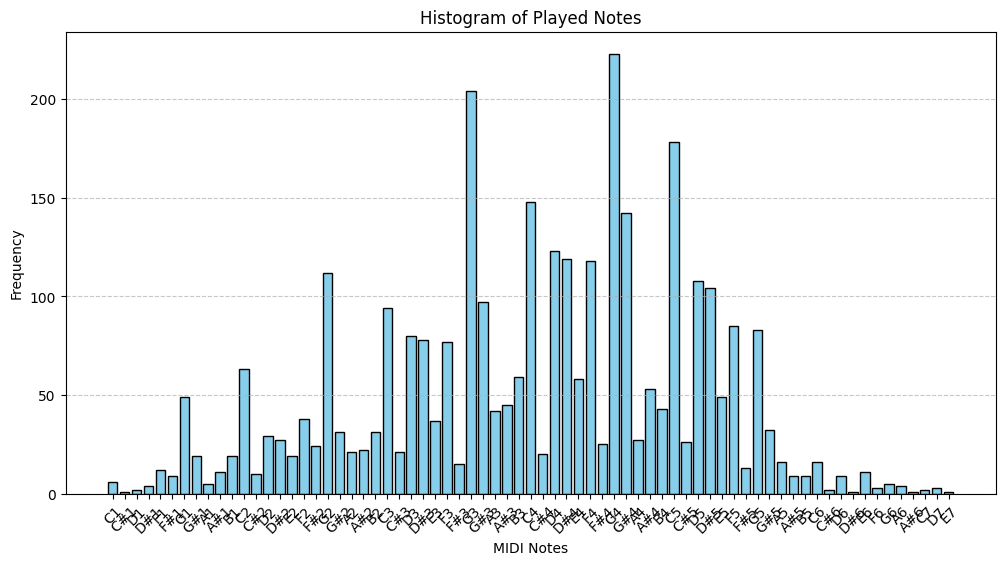

In [7]:

# Extract played notes
note_counts = Counter()

for track in midi_file.tracks:
    for msg in track:
        if msg.type == 'note_on' and msg.velocity > 0:  # Ignore note_off
            note_counts[msg.note] += 1  # Count note occurrences

# Sort notes
notes = sorted(note_counts.keys())
frequencies = [note_counts[n] for n in notes]

# Convert MIDI numbers to note names
def midi_to_note(midi_num):
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = (midi_num // 12) - 1  # MIDI note number to octave
    note = note_names[midi_num % 12]
    return f"{note}{octave}"

note_labels = [midi_to_note(n) for n in notes]

# Plot histogram
plt.figure(figsize=(12, 6))
plt.bar(note_labels, frequencies, color='skyblue', edgecolor='black')

plt.xlabel("MIDI Notes")
plt.ylabel("Frequency")
plt.title("Histogram of Played Notes")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [8]:
# Track note states
active_notes = {}  # Stores active notes {note: velocity}
time_series = []
timestamps = []
time_elapsed = 0

for msg in midi_file:
    time_elapsed += msg.time
    
    if msg.type == 'note_on' and msg.velocity > 0:
        active_notes[msg.note] = msg.velocity  # Note is played with a velocity
    elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
        active_notes.pop(msg.note, None)  # Note is released
    
    # Snapshot at each time step
    timestamps.append(time_elapsed)
    snapshot = [active_notes.get(note, 0) for note in range(21, 109)]  # MIDI range (A0 to C8)
    time_series.append(snapshot)

# Convert to NumPy array
note_matrix = np.array(time_series)
print(note_matrix.shape)


(6963, 88)


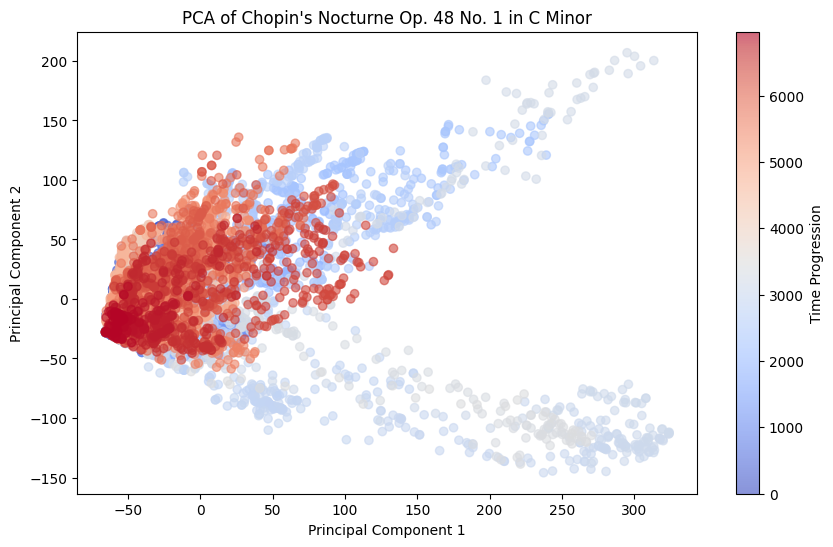

In [9]:
# Apply PCA
pca = PCA(n_components=2)
transformed = pca.fit_transform(note_matrix)

# Plot PCA results
plt.figure(figsize=(10, 6))
plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.6, c=range(len(transformed)), cmap='coolwarm')
plt.colorbar(label="Time Progression")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Chopin's Nocturne Op. 48 No. 1 in C Minor")
plt.show()

/Users/kevinhan/opt/anaconda3/envs/musicGen/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


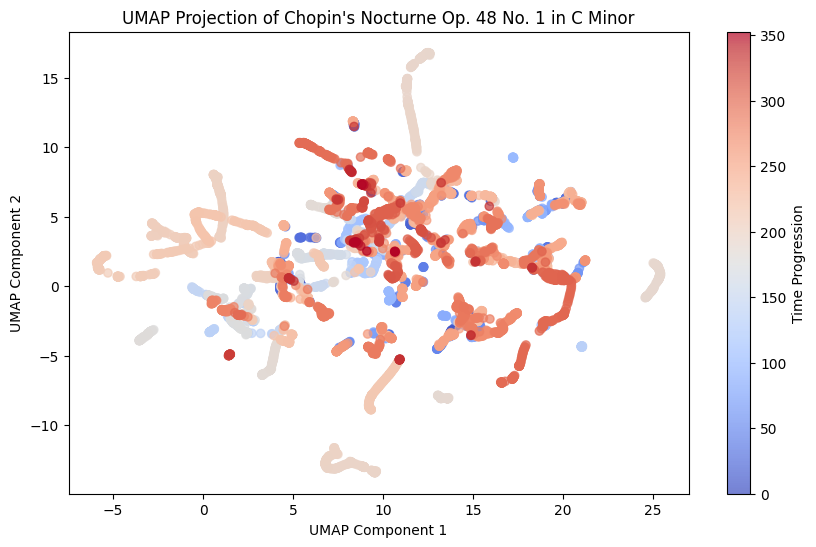

In [10]:
# Track note states
active_notes = {}  # Stores active notes {note: velocity}
time_series = []
timestamps = []
time_elapsed = 0

for msg in midi_file:
    time_elapsed += msg.time
    
    if msg.type == 'note_on' and msg.velocity > 0:
        active_notes[msg.note] = msg.velocity  # Note is played with a velocity
    elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
        active_notes.pop(msg.note, None)  # Note is released
    
    # Snapshot at each time step
    timestamps.append(time_elapsed)
    snapshot = [active_notes.get(note, 0) for note in range(21, 109)]  # MIDI range (A0 to C8)
    time_series.append(snapshot)

# Convert to NumPy array
note_matrix = np.array(time_series)

# Apply UMAP (reduce note matrix to 2D)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
embedded = reducer.fit_transform(note_matrix)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(embedded[:, 0], embedded[:, 1], c=timestamps, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Time Progression")
plt.title("UMAP Projection of Chopin's Nocturne Op. 48 No. 1 in C Minor")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()
